In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(file_url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


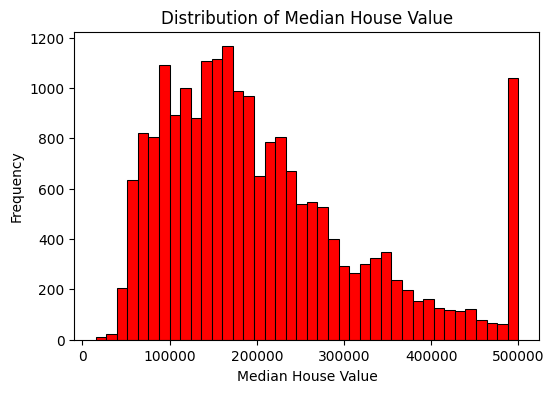

In [2]:
# eda: plot median_house_value 
plt.figure(figsize=(6,4))
sns.histplot(df.median_house_value, bins=40, color='red', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Median House Value')
plt.title('Distribution of Median House Value')
plt.show()

In [3]:
# select relevant data
relevant_proximities = ['<1H OCEAN','INLAND']
relevant_columns = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
df = df[df['ocean_proximity'].isin(relevant_proximities)][relevant_columns]

### Question 1

In [4]:
df.columns[df.isna().any()] # or df.notnull().all(axis=0)

Index(['total_bedrooms'], dtype='object')

### Question 2

In [5]:
df.population.median()

1195.0

In [6]:
# shuffle the dataset using seed 42
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

In [7]:
# split the data in train/val/test sets, with 60%/20%/20% distribution
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

df_train=df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
df_val=df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
df_test=df_shuffled.iloc[n_train+n_val:].copy().reset_index(drop=True)

In [8]:
# apply the log transformation to the median_house_value variable using the np.log1p() function
y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)

In [9]:
# create linear regression function
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [10]:
# create fill na function
check = list(filter(lambda x: x != 'median_house_value', df.columns))

def prepare_X(df, fillna_value):
    df_num = df[check]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [11]:
# create root mean squared error function
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [12]:
# remove target variable from training data set
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
# create function to fill NA, train linear regression w/o regularization, and calculate rmse 
def prepare_train_eval(train_X, train_y, val_X, val_y, fillna_value=0):
    X_train = prepare_X(train_X, fillna_value)
    X_val = prepare_X(val_X, fillna_value)
    w_0, w = train_linear_regression(X_train, train_y)
    y_pred = w_0 + X_val.dot(w)
    return round(rmse(val_y, y_pred),2)

### Question 3

In [14]:
rmse_zero = prepare_train_eval(df_train, y_train, df_val, y_val, 0)
rmse_mean = prepare_train_eval(df_train, y_train, df_val, y_val, df_train['total_bedrooms'].mean())
print(f'When filling NAs with 0 the RMSE is {rmse_zero}')
print(f'When filling NAs with the mean value the RMSE is {rmse_mean}')

When filling NAs with 0 the RMSE is 0.34
When filling NAs with the mean value the RMSE is 0.34


In [15]:
# create linear regression with regularization function 
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye((XTX.shape[0]))
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [16]:
# select best regularization value
X_train=prepare_X(df_train, 0)
X_val=prepare_X(df_val, 0)

reg_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
w_0_values = []
rmse_values = []
for r in reg_values:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_pred),2)
    w_0_values.append(np.round(w_0,3))
    rmse_values.append(rmse_val)

results_dict = {'r':reg_values, 'w_0':w_0_values, 'rmse':rmse_values}
df_reg_results = pd.DataFrame(results_dict)
df_reg_results

,r,w_0,rmse
0,0.000000,-9.763,0.34
1,0.000001,-9.763,0.34
2,0.000100,-9.761,0.34
3,0.001000,-9.743,0.34
4,0.010000,-9.561,0.34
5,0.100000,-8.059,0.34
6,1.000000,-3.133,0.34
7,5.000000,-0.841,0.35
8,10.000000,-0.438,0.35


### Question 4

In [17]:
min_rmse = df_reg_results.rmse.min()
min_r = df_reg_results.r.min()

mask_rmse = df_reg_results['rmse'] == min_rmse
mask_r = df_reg_results['r'] == min_r

df_reg_results[mask_rmse & mask_r]['r']

0    0.0
Name: r, dtype: float64

In [18]:
# create shuffle function
def shuffle(s, df):
    n = len(df)
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    return df_shuffled

# create split function
def split(df_shuffled, n_train, n_val, n_test):
    df_train=df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
    df_val=df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
    df_test=df_shuffled.iloc[n_train+n_val:].copy().reset_index(drop=True)
    
    y_train = np.log1p(df_train.median_house_value)
    y_val = np.log1p(df_val.median_house_value)
    y_test = np.log1p(df_test.median_house_value)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    return [df_train, y_train], [df_val, y_val], [df_test, y_test]

# create shuffle and split function
def shuffle_split(s, df):
    df_shuffled = shuffle(s, df)
    return split(df_shuffled, n_train, n_val, n_test)

In [19]:
# evalute seed impact
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_values = []

for seed in seed_values:
    train_data, val_data, test_data = shuffle_split(seed,df)
    # fill missing values with 0
    X_train = prepare_X(train_data[0], 0)
    X_val = prepare_X(val_data[0], 0)
    # train linear regression w/o regularization
    w_0, w = train_linear_regression(X_train, train_data[1])
    y_pred = w_0 + X_val.dot(w)
    # calculate rmse
    rmse_values.append(rmse(val_data[1], y_pred))

pd.concat([
    pd.Series(seed_values, name='seeds'),
    pd.Series(rmse_values, name='rmse')
], axis=1)

,seeds,rmse
0,0,0.337739
1,1,0.337800
2,2,0.338429
3,3,0.332005
4,4,0.339445
5,5,0.343382
6,6,0.338533
7,7,0.346875
8,8,0.351274
9,9,0.334156


### Question 5

In [20]:
np.round(np.std(rmse_values), 3)

0.005

In [21]:
# evaluate seed + regularization
seed = 9
train_data, val_data, test_data = shuffle_split(seed,df)

df_train = pd.concat([train_data[0], val_data[0]]).reset_index(drop=True)
df_test = test_data[0]

y_train = pd.concat([train_data[1],val_data[1]]).reset_index(drop=True)
y_test = test_data[1]

X_train = prepare_X(df_train, 0)
X_test = prepare_X(df_test, 0)

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)

### Question 6

In [22]:
np.round(rmse(y_test, y_pred), 2)

0.33